In [75]:
import collections
import networkx as nx
import h5py
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

In [4]:
h5 = h5py.File('arb_8204_traj.h5', 'r')

In [9]:
type_id2atomtype = {int(x[0]): x[1] for x in list(h5['/parameters/force_field/atomtypes'])}
print type_id2atomtype

{0: 'MA', 1: 'ML', 2: 'DA', 3: 'FA', 4: 'PA', 5: 'RA', 6: 'PL'}


In [87]:
static_cl = h5['/connectivity/bonds_0']
cl = h5['/connectivity/chem_bonds_0/value'][-1]
species = h5['/particles/atoms/species/value'][-1]
ids = h5['/particles/atoms/id/value'][-1]
res_id = h5['/particles/atoms/res_id/value'][-1]

In [24]:
g = nx.Graph()
for at_id, sp in enumerate(species, 1):
    if sp != -1:
        g.add_node(at_id, atom_type=type_id2atomtype[sp])

In [25]:
g.add_edges_from([b for b in static_cl if -1 not in b])
g.add_edges_from([b for b in cl if -1 not in b])

In [26]:
g.number_of_edges()

4445

In [28]:
g_degree = g.degree()
type_degree = collections.defaultdict(list)
for g_id, deg in g_degree.items():
    node = g.node[g_id]
    type_degree[node['atom_type']].append(deg)

In [31]:
for type_name, deg_list in type_degree.items():
    print('{} min={} max={}'.format(type_name, min(deg_list), max(deg_list)))

MA min=1 max=1
ML min=2 max=2
DA min=2 max=2
FA min=2 max=2
PA min=1 max=1
RA min=3 max=3
PL min=2 max=2


In [88]:
atom_id2res_id = {}
res_id2atom_list = collections.defaultdict(list)
for at_id, reid in enumerate(res_id, 1):
    if reid != -1:
        atom_id2res_id[at_id] = reid
        res_id2atom_list[reid].append(at_id)

In [68]:
cg_g = nx.MultiGraph()
cg_bonds = []
for b in cl:
    if -1 not in b:
        res_id1, res_id2 = map(atom_id2res_id.get, b)
        if res_id1 != res_id2:
            cg_g.add_edge(res_id1, res_id2)
            cg_bonds.append((res_id1, res_id2))
        else:
            print res_id1, res_id2, b

In [81]:
cg_g_degree = cg_g.degree()

In [69]:
cg_g.number_of_edges()

445

In [126]:
from networkx.drawing.nx_agraph import graphviz_layout
def draw_graph(g, **kwargs):
    g_degree = g.degree()
    pos = graphviz_layout(g)
    node_colors = {1: 'r', 2: 'g', 3: 'y', 4: 'b'}
    nx.draw_networkx(g, pos, node_size=500, font_size=12, alpha=0.5, labels=g_degree,
                     node_color=[node_colors[g_degree[x]] for x in g.nodes()], **kwargs)
    plt.xticks([])
    plt.yticks([])

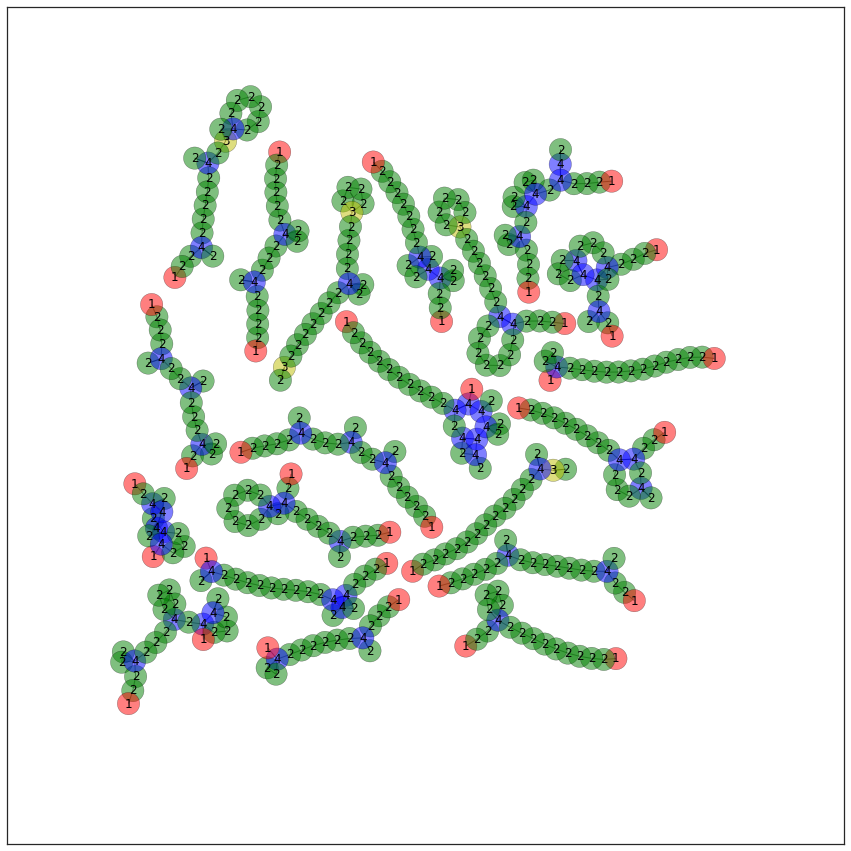

In [121]:
plt.rcParams['figure.figsize'] = (15, 15)
draw_graph(cg_g)


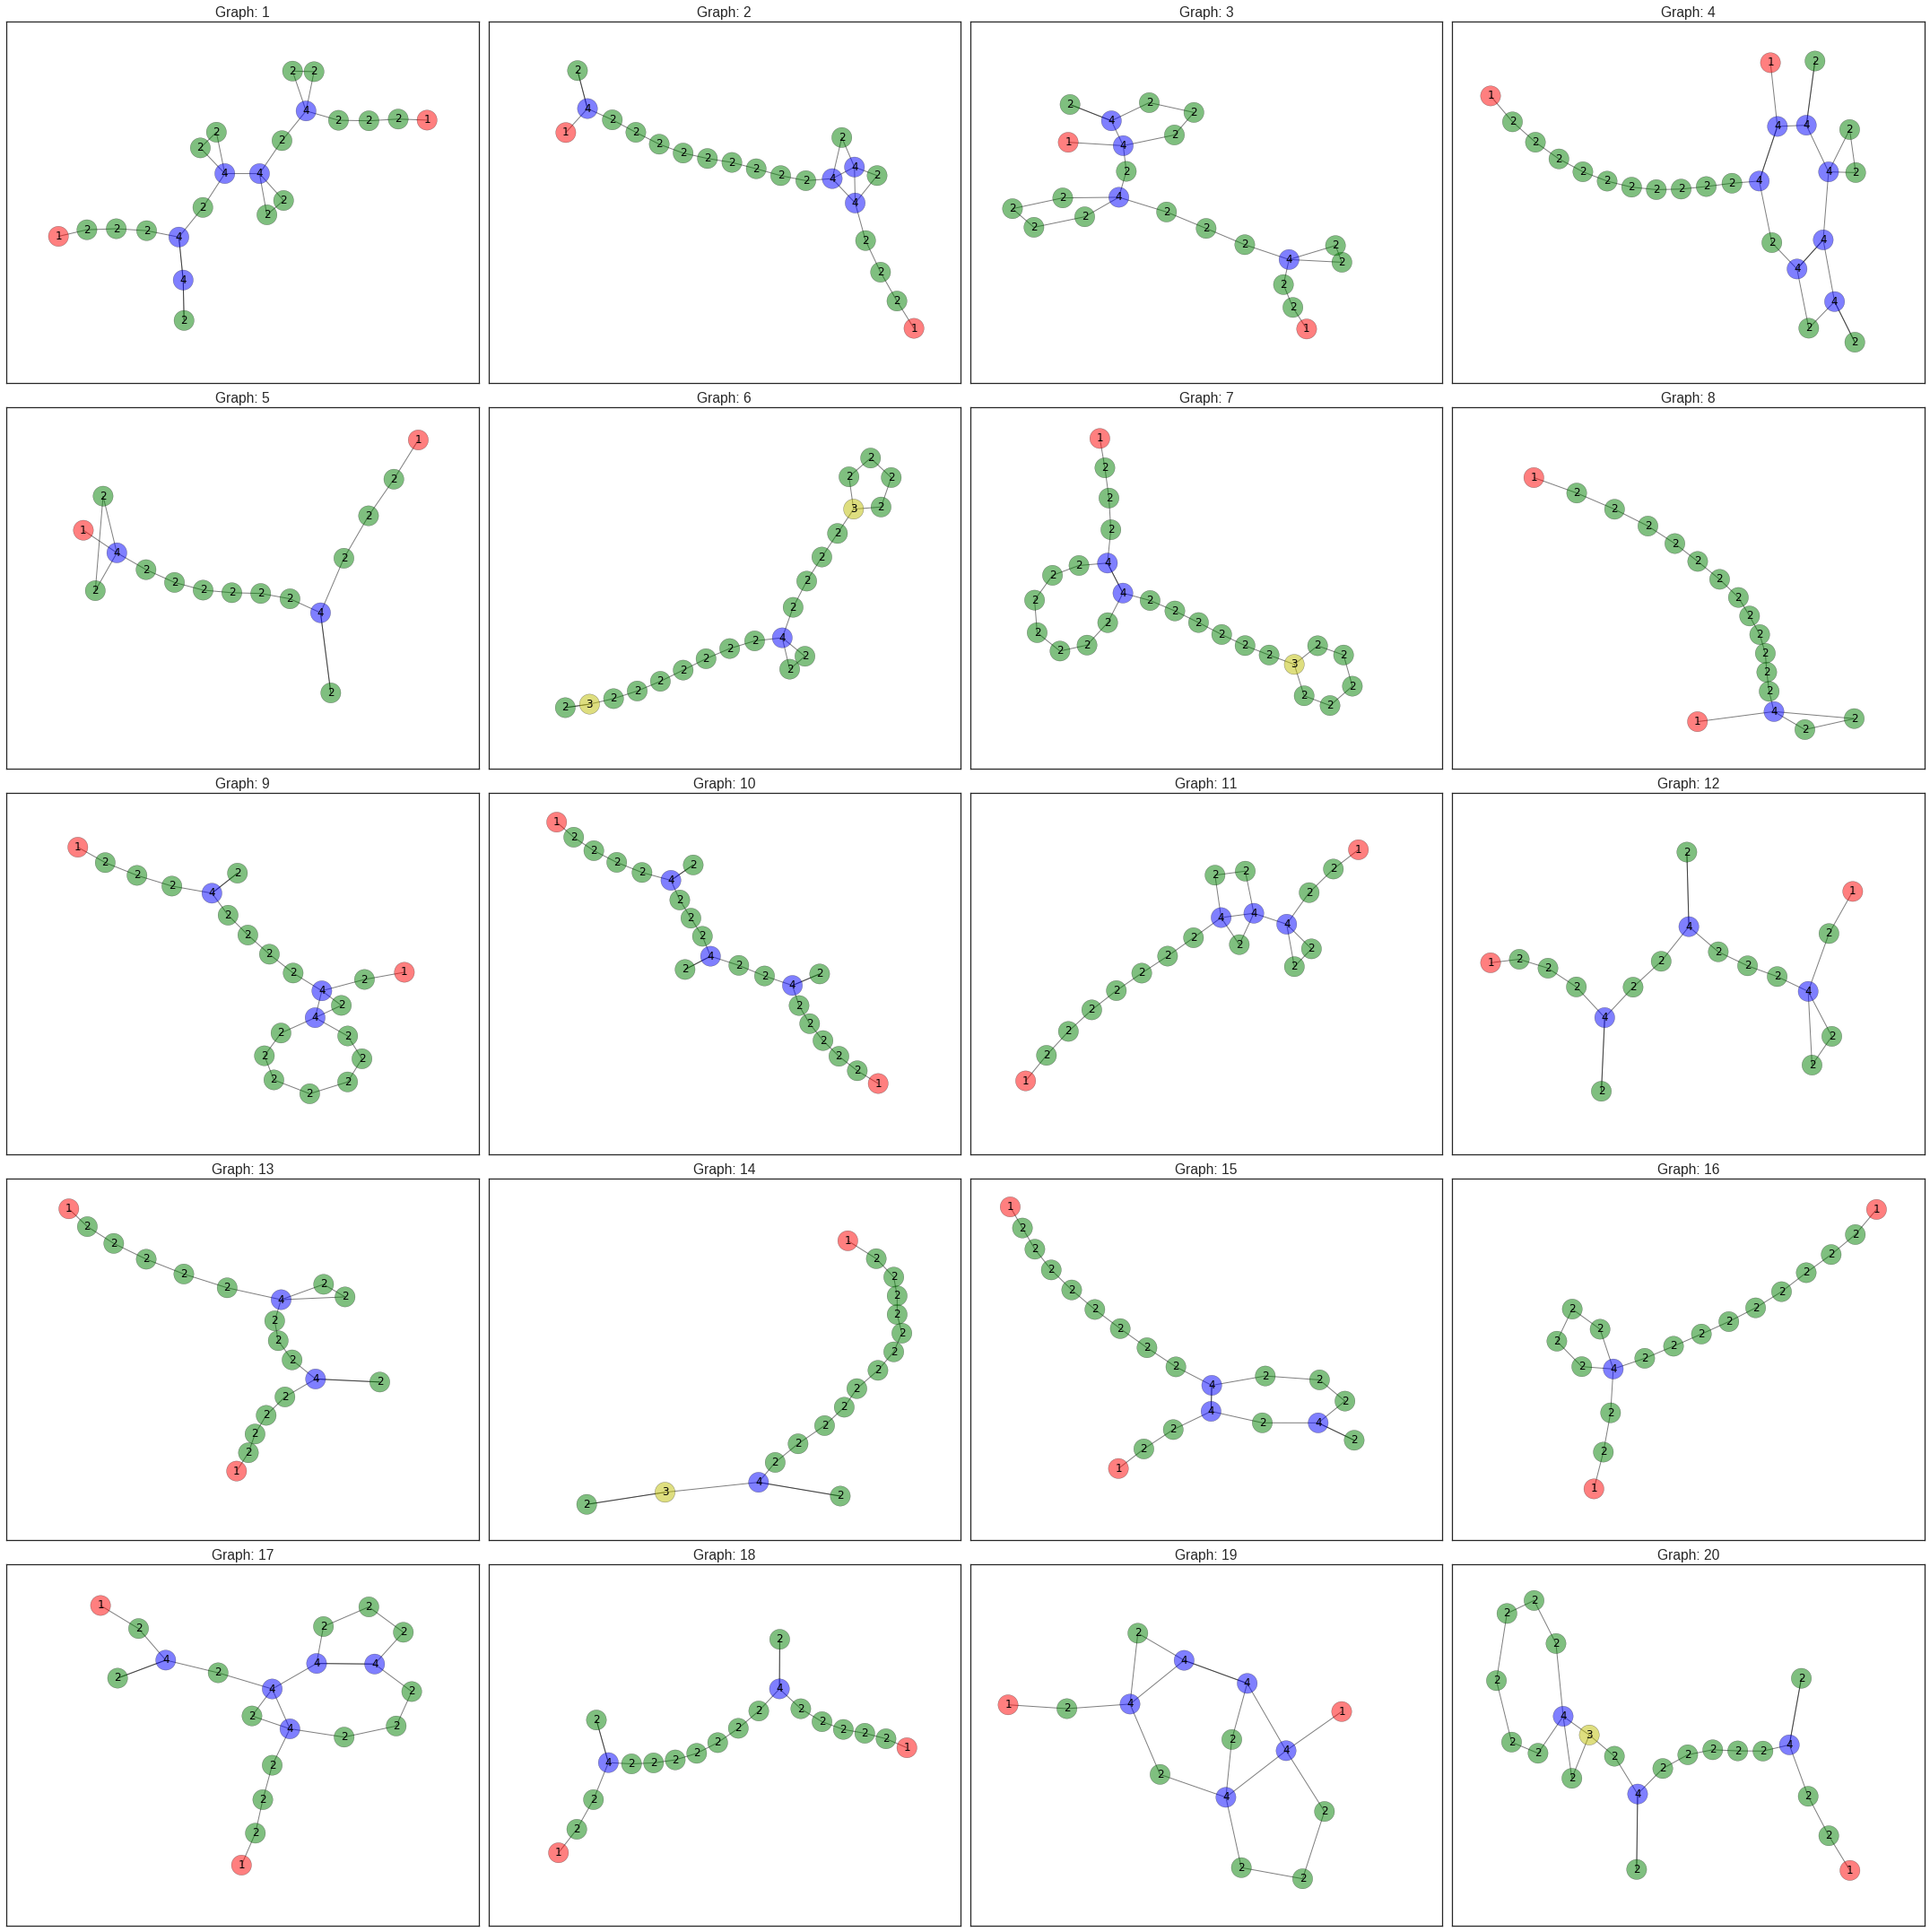

In [122]:
plt.rcParams['figure.figsize'] = (30, 30)
for cg_id, cg_s in enumerate(nx.connected_component_subgraphs(cg_g), 1):
    plt.subplot(nx.number_connected_components(cg_g)/ 4, 4, cg_id)
    at_ids = [a for r in cg_s.nodes() for a in res_id2atom_list[r]]
    #draw_graph(g, nodelist=at_ids)
    draw_graph(cg_s)
    plt.title('Graph: {}'.format(cg_id))
plt.tight_layout()

66 22


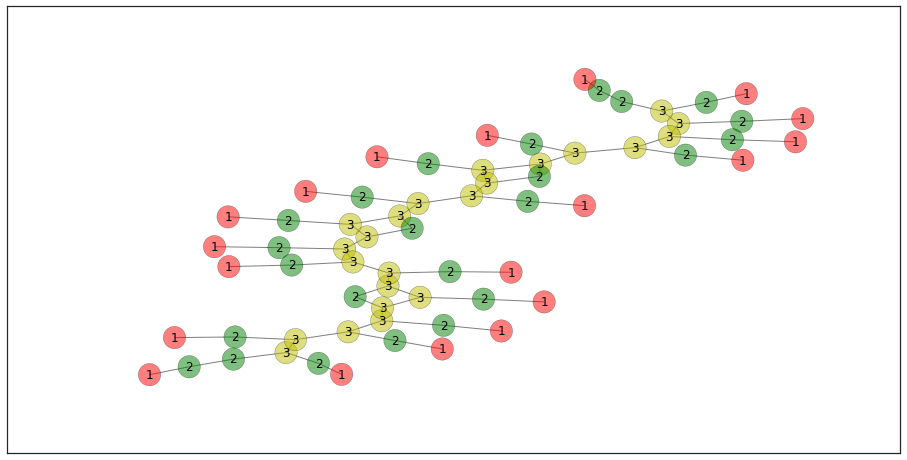

In [127]:
cg_g_9 = list(nx.connected_component_subgraphs(cg_g))[9]
at_ids = [a for r in cg_g_9.nodes() for a in res_id2atom_list[r]]
print len(at_ids), cg_g_9.number_of_nodes()
plt.rcParams['figure.figsize'] = (16, 8)
#plt.subplot(1,2,1)
draw_graph(nx.subgraph(g, at_ids))
#plt.subplot(1,2,2)
#draw_graph(cg_g_9)